In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy

# Markov Chain Monte Carlo

- Addressing how we compute posterior distributions

Returning to the marriage example earlier, we only have a sample from each state (they are only **estimates**)

Need to take into accoutn the estimates & other influencing variables (like population, smaller states will have less data and will have higher innaccuracy) 

## Real, latent modeling problems 

- Testing knowledge
- Journal refereeing
- Social networks

Features of them:

- Many unknowns 
- Nested relationships
- Bounded outcomes
- Difficult calculations

## Computing the posterior

1. Analytical approach (often impossible)
    - Only possible for simple problems, needs to be correctly structure
2. Grid approximation (very intensive)
    - Dimensionality of grid grows with number of unknowns
3. Quadratic approximation (limited)
    - Similar to maximum likelihood
    - Lots of posteriors that aren't multivariate gaussian
    - makes strong assumptions
4. **Markov Chain Monte Carlo (intensive)**
    - Used on wide range of problems
    - scales well

## Markov Chain

Simple Metropolis-type algorithm

1. Find proposol location
2. Find "population" of location
3. Find "population" of current island
4. Move to proposal, with probability = (pop. proposed)/(prop. current)
5. Repeat

Ensures you visit each location in proportion to its population, in the long run

Actual use: Draw samples from a posterior distribution

"Islands": parameter values
    
    - Unknowns, candidate explanations

"Population size": posterior probability

Visit each parameter value in proportion to its posterior probability

Any number of dimensions (parameters)

Calculates an "integral" by sampling

Chain: Sequence of draws from distribution

Markov chain: History doesn't matter, just where you are now 

Monte Carlo: Random simulation 

## Samplers

Lots of sampler options in PYMC, can chose versions of Metropolis if you like. I usually let PYMC chose whatever it thinks is best 

Can choose HamiltonianMC if you like. But NUTS (No U-Turn Sampler) appears to be a better version of it? (I don't know much, I just accept what experts say)

## Judgment at Princeton 



Wine Quality (Q unobserved) -> Score (S) <- Judge (J unobserved)

Wine origin -> Wine Quality

Wine origin -> Score

Judge origin -> Judge 

Estimand: Association between wine quality and wine origin. Stratify by judge for efficiency. 

Judges have their own biases, some are harsh/easy/discriminating. 

The judgee differences obscure the ability to estimate the quality. 

Can use latent variable models, item response models. 

In [2]:
wines = pd.read_csv('Data/Wines2012.csv',sep=';')
wines.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


In [3]:
## Working with a lot more categories of things
W = wines['wine'].astype('category')
W.cat.codes

0       0
1       2
2       4
3       6
4       8
       ..
175    11
176    13
177    15
178    17
179    19
Length: 180, dtype: int8

In [4]:
W.cat.codes.nunique()

20

In [5]:
with pm.Model() as wine_m:
    S = scale(wines['score'])
    J = wines['judge']
    W = wines['wine'].astype('category').cat.codes
    X = wines['wine.amer']
    Z = wines['judge.amer']
    
    sigma = pm.Exponential('sigma',1)
    Q     = pm.Normal('Q',0,1,shape=W.nunique())
    mu    = Q[W]
    S     = pm.Normal('S',mu,sigma,observed=S)
    wine_samp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [6]:
wine_m

sigma ~ Exp(f())
    Q ~ N(0, 1)
    S ~ N(f(Q), sigma)

In [7]:
az.summary(wine_samp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[0],0.140,0.314,-0.451,0.719,0.003,0.005,8596.0,2824.0,1.0
Q[1],0.106,0.322,-0.462,0.765,0.004,0.005,7924.0,2609.0,1.0
Q[2],0.268,0.308,-0.334,0.837,0.003,0.004,9220.0,2100.0,1.0
Q[3],0.555,0.310,-0.040,1.127,0.003,0.003,9891.0,3012.0,1.0
Q[4],-0.126,0.306,-0.683,0.462,0.003,0.005,8846.0,2532.0,1.0
Q[5],-0.373,0.314,-0.973,0.196,0.003,0.003,9029.0,2686.0,1.0
Q[6],0.286,0.324,-0.316,0.890,0.003,0.004,8665.0,2820.0,1.0
Q[7],0.267,0.316,-0.323,0.873,0.003,0.004,9153.0,2790.0,1.0
Q[8],0.086,0.313,-0.495,0.661,0.003,0.005,8677.0,2928.0,1.0
Q[9],0.119,0.322,-0.480,0.736,0.003,0.005,10627.0,3079.0,1.0


## Drawing the Markov Owl

Complex machinery, lots of diagnostics

1. Trace plots
2. Trace rank plots
3. R-hat convergence measure
4. Number of effective samples
5. Divergent transitions

array([[<AxesSubplot: title={'center': 'Q'}>,
        <AxesSubplot: title={'center': 'Q'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

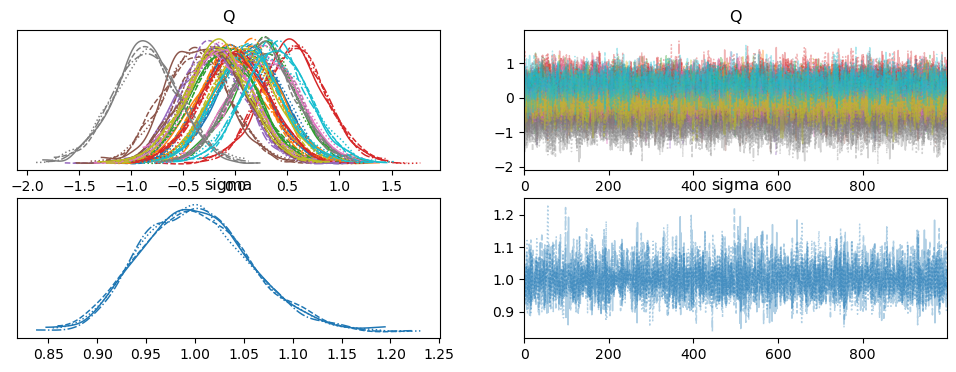

In [8]:
az.plot_trace(wine_samp)

array([[<AxesSubplot: title={'center': 'Q\n0'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n1'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n2'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot: title={'center': 'Q\n3'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n4'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n5'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot: title={'center': 'Q\n6'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n7'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n8'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot: title={'center': 'Q\n9'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n10'}, xlabel='Rank (all chains)'>,
        <AxesSubplot: title={'center': 'Q\n11'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot: title={'center': 'Q\n12'}, xlabel='Rank (all cha

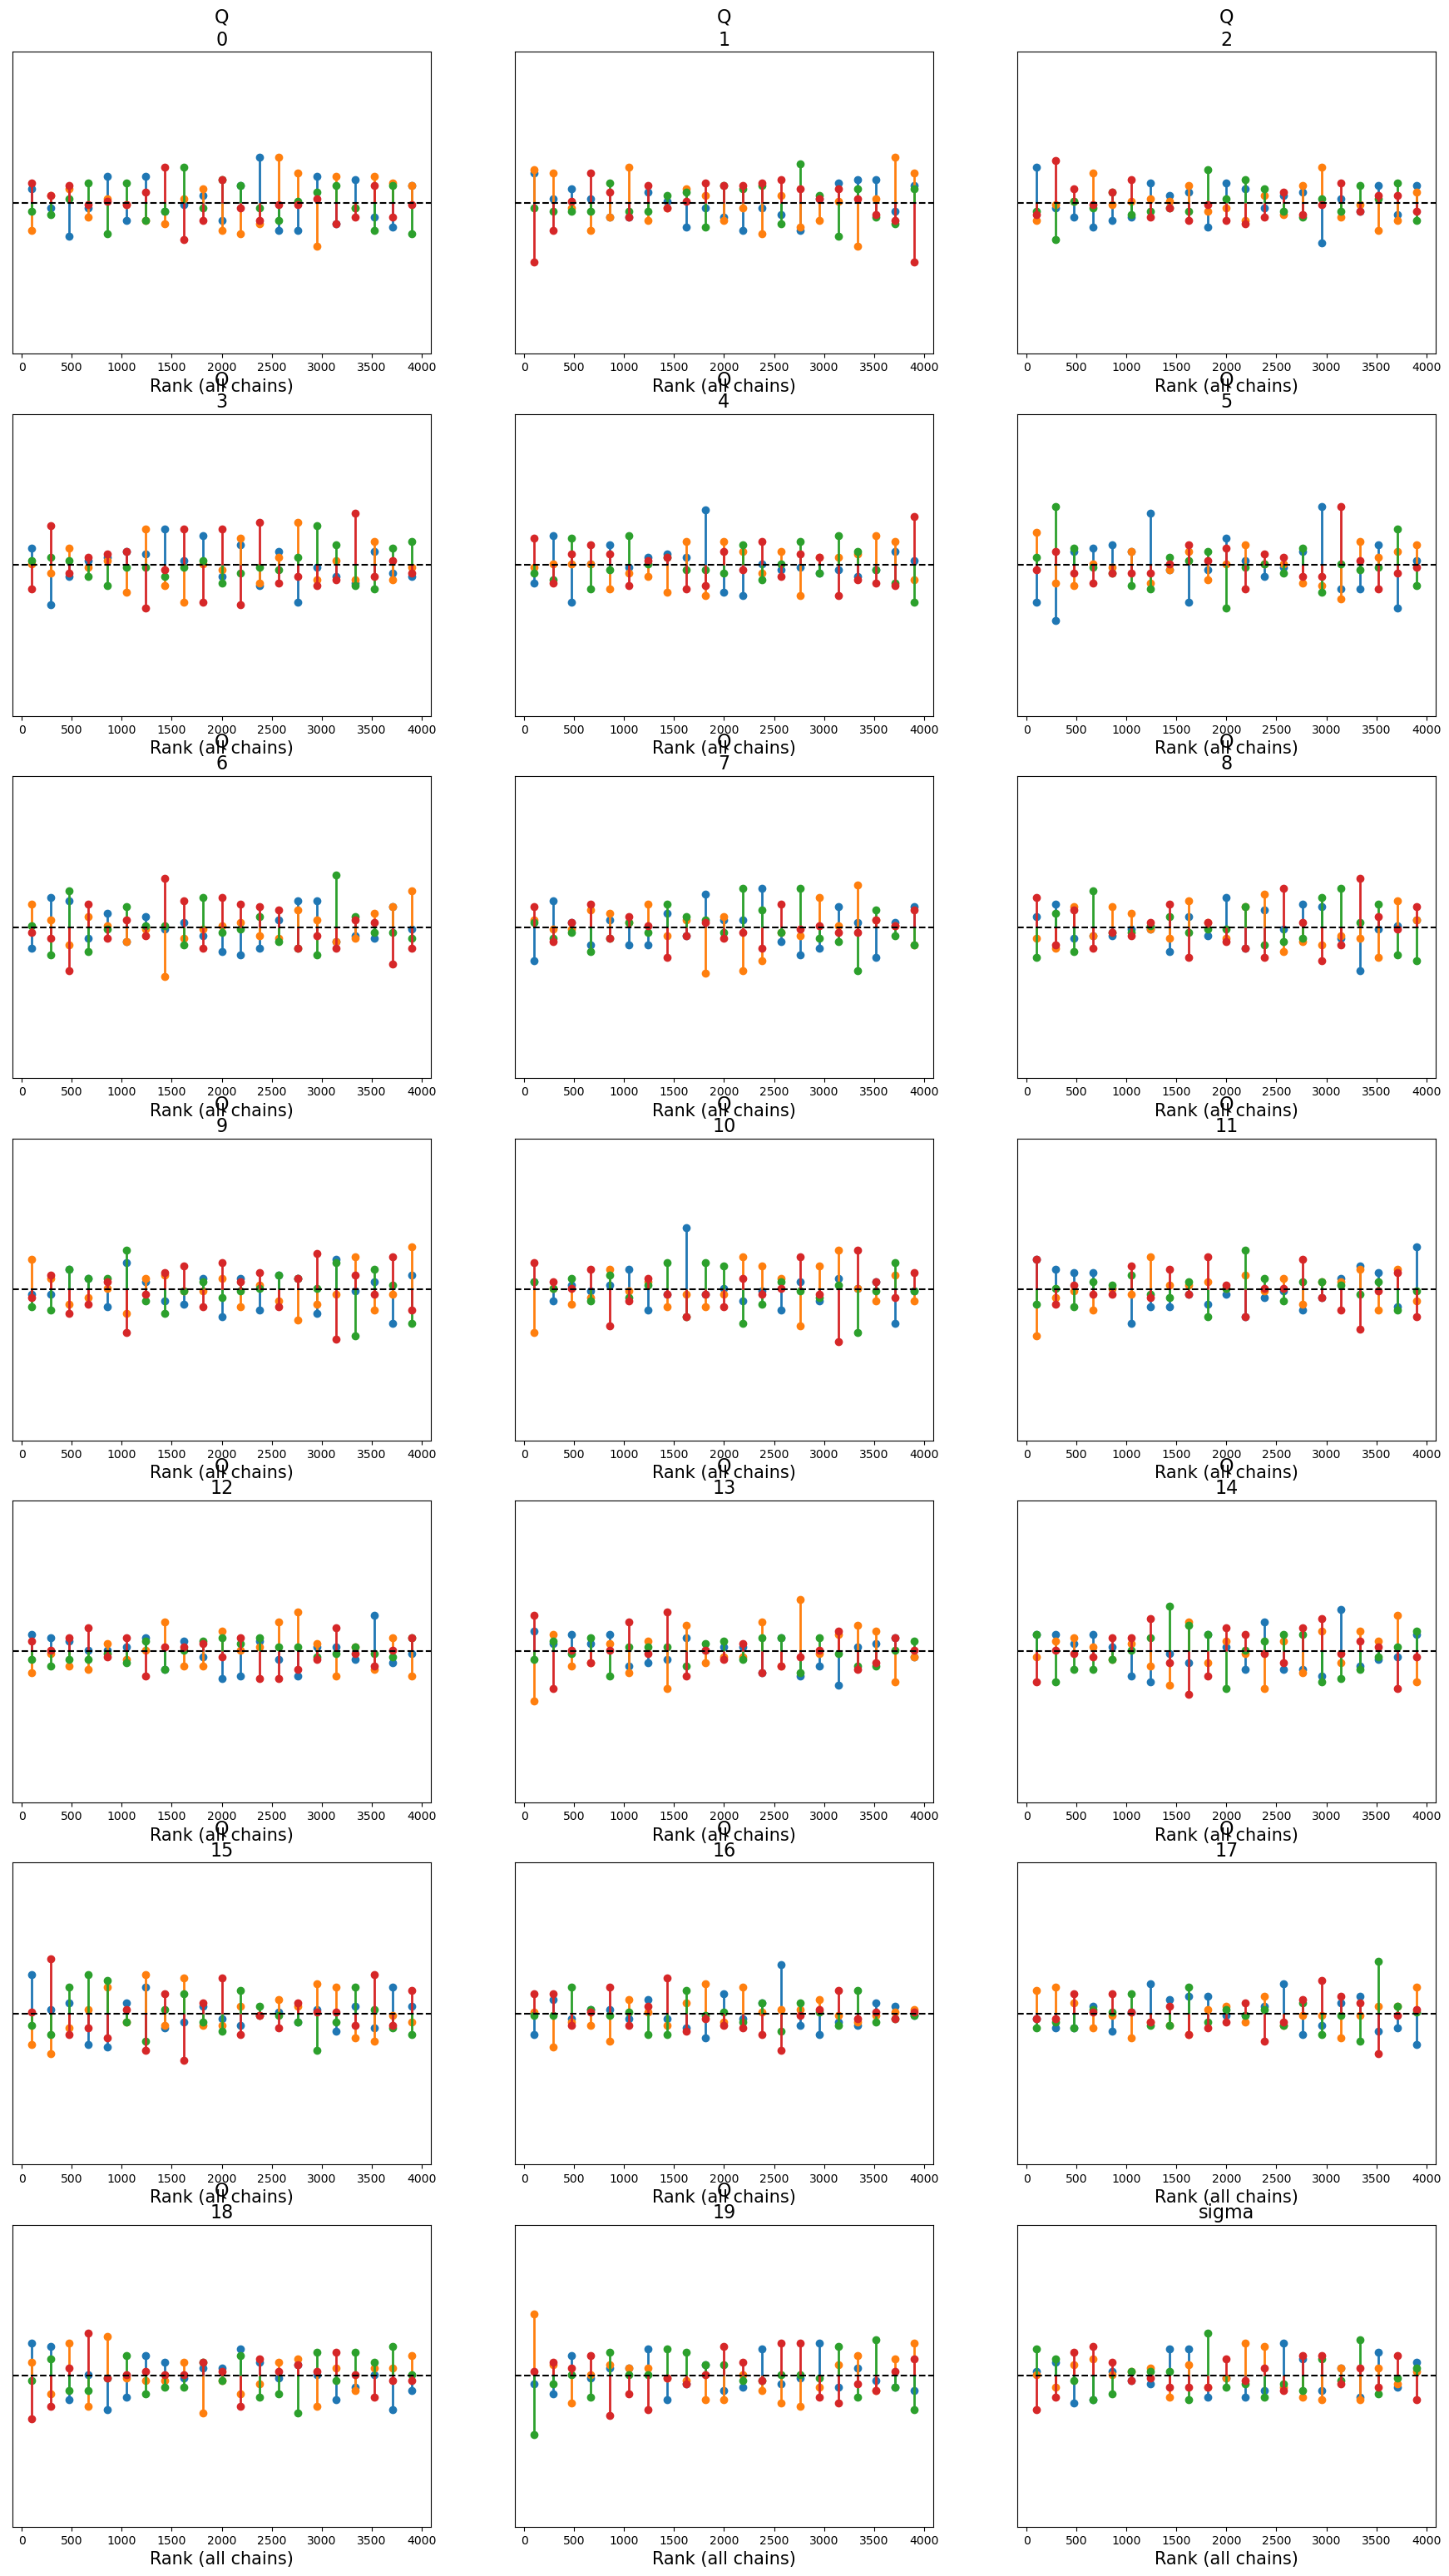

In [9]:
az.plot_rank(wine_samp, kind="vlines")

For the above we want the colors to mix along the way, no one being on top or bottom more than any other. Fuzzy caterpillars and convergence. 

## R-hat

When chains converge:

1. Start and end of each chain explores same region
2. Independent chains explore same region

R-hat is a ratio of variances:

As total variance shrings to average variance within chains, R-hat approachs 1

can happen very quickly for good chains. 

Over 1.1 or 1.2 should think about fiddling or fixing possible issues. 

NO GUARANTEES, NOT A TEST 

## n_eff

Estimate of number of effective samples

"How long would the chain be, if each sample was independent of the one before it?"

When samples are autocorrelated, you have fewer effective samples. 

Typically n_eff will be smaller than samples taken, because perfect chain will need fewer samples 

n_eff can be larger than the number of sampels taken. It's just done a very good job

In [10]:
with pm.Model() as wine_m2:
    S = scale(wines['score'])
    J = wines['judge']
    W = wines['wine'].astype('category').cat.codes
    X = wines['wine.amer']
    Z = wines['judge.amer']
    
    sigma = pm.Exponential('sigma',1)
    Q     = pm.Normal('Q',0,1,shape=W.nunique())
    O     = pm.Normal('O',0,1,shape=X.nunique())
    
    mu    = Q[W] + O[X]
    S     = pm.Normal('S',mu,sigma,observed=S)
    wine_samp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Q, O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


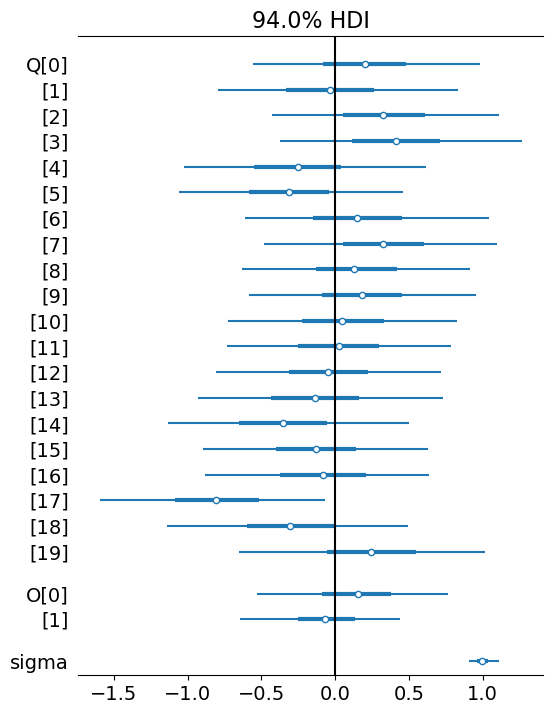

In [11]:
az.plot_forest(wine_samp,combined=True)
plt.axvline(x = 0, color = 'black')

In [12]:
with pm.Model() as wine_m3:
    S = scale(wines['score'])
    J = wines['judge'].astype('category').cat.codes
    W = wines['wine'].astype('category').cat.codes
    X = wines['wine.amer']
    Z = wines['judge.amer']
    
    sigma = pm.Exponential('sigma',1)
    Q     = pm.Normal('Q',0,1,shape=W.nunique())
    O     = pm.Normal('O',0,1,shape=X.nunique())
    H     = pm.Normal('H',0,1,shape=J.nunique())
    D     = pm.Exponential('D',1,shape=J.nunique())
    
    mu    = (Q[W] + O[X] - H[J])*D[J]
    S     = pm.Normal('S',mu,sigma,observed=S)
    wine_samp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Q, O, H, D]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [13]:
wine_m3

sigma ~ Exp(f())
    Q ~ N(0, 1)
    O ~ N(0, 1)
    H ~ N(0, 1)
    D ~ Exp(f())
    S ~ N(f(D, H, O, Q), sigma)

mu = Expected Score

Q  = Wine quality (per wine!)

O  = Origin (peer origin!)

H  = Judge harshness (per judge!)

D  = Judge discrimination (per judge!) (Very low value means they assign all scores to be average

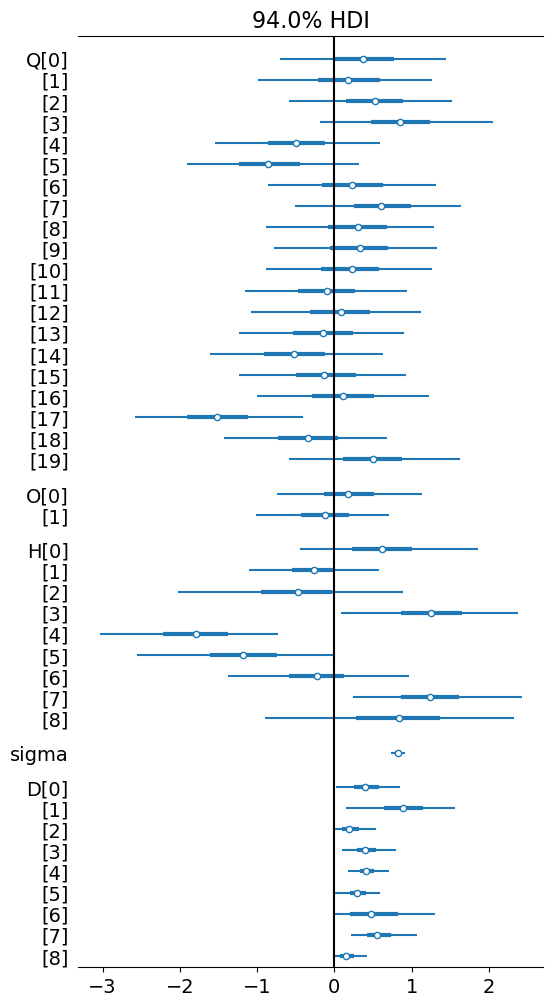

In [14]:
az.plot_forest(wine_samp,combined=True)
plt.axvline(x = 0, color = 'black')

# "When you have computational problems, often there's a problem with your model." - Andrew Gelman

## Divergent Transitions

Divergent transition: A kind of reject proposal

Simulation diverges from true path

Many DTs: poor exploration & possible bias
